In [1]:
import comp_viz
import gluoncv
import mxnet
import numpy
import matplotlib
files = {0: ('datasets/person_0/images/0a4fabbe64fc3af8_jpg.rf.5cb3ebba3cc1dd5b4f7b37cf3ee87e35.jpg',"datasets/person_0/labelTxt/0a4fabbe64fc3af8_jpg.rf.5cb3ebba3cc1dd5b4f7b37cf3ee87e35.txt")}
network = comp_viz.utils.ObjectDetection.get_networks()[3]
model = comp_viz.object_detection.Model(network)
model.set_classes(['person'])
img = comp_viz.utils.Tools.get_mxnet_image(files[0][0])

Complete. Model set to detect for object classes: ['person'].


In [ ]:
def get_detections(fname):
  detections = []
  with open(fname) as f:
    for thing in f:
      l = thing.split(" ")
      detection = []
      detection += l[1:5]
      detection = [int(val) for val in detection]
      detections.append(detection)
  return detections

{'image': 'datasets/person_0/images/0a4fabbe64fc3af8_jpg.rf.5cb3ebba3cc1dd5b4f7b37cf3ee87e35.jpg', 'class_ids': [0], 'confidence_scores': [0.988], 'bounding_boxes': [[25.0, 11.0, 226.0, 405.0]], 'nms_thresh': 0, 'class_map': {0: 'person'}, 'time': 1.8249}


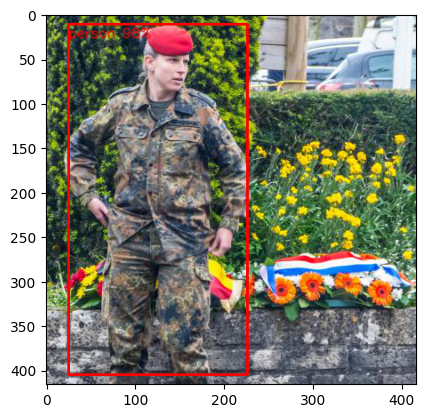

In [3]:
model.show_image_prediction(files[0][0])

In [7]:
l = [val for val in pred["class_map"].keys()]
print(l)

[0]


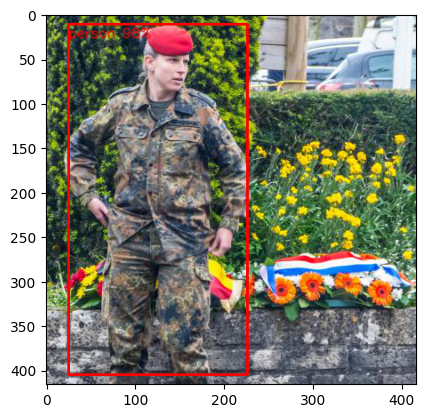

In [3]:
comp_viz.utils.ObjectDetection.show_pred_bboxes_image(files[0][0],pred["bounding_boxes"],[key for key in pred["class_map"].keys()],[val for val in pred["class_map"].values()],pred["confidence_scores"])